In [ ]:
#https://creativecommons.org/licenses/by/4.0/

This file aims at creating a useful pandas-based dataframework for each subject.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.io
import pandas as pd
from glob import glob
import os
import time
from scipy import signal
import csv

In [2]:
import pylab

Channels and sampling frequency

In [3]:
fs = 2048 #Hz, sampling frequency
n_ch = 8 #channles in one row (or column) of one set
n_ch_tot = (n_ch**2)*3 #total channels

# Data

Create dataframe

In [4]:
columns = ['task','trial',
           'set1','set2','set3',
          't_steps', 'time_duration']#,
           #'info', 'side','gain','filt_parameters','notes']
        #to add further info

#add channels as predictors

for i in range(n_ch_tot):
    columns.append('ch'+str(i+1),)

df = pd.DataFrame(columns=columns)

ch_col = df.columns[ df.columns.get_loc('ch1') : df.columns.get_loc('ch1') + n_ch_tot]

Select tasks

In [5]:
task_names = [#'iso',
              'bottle',
              'screw',
              'knife',
              'hammer',
              'peg',
              #'free_eating',
              'jar', 
              'typing']
              #'swing']

Choose subject

In [6]:
folder = '20181024_KONSENS_recordings/S1/'

Load selected tasks from chosen subject into dataframe

In [7]:
file_list = []
task_list_name = []
task_list_num = []

for task_num, task_name in enumerate(task_names):
    
    file_list_temp = glob(os.path.join(folder, '*'+task_name+'*.mat'))
    file_list.extend(file_list_temp)
    task_list_name.extend((task_name,)*np.size(file_list_temp))
    task_list_num.extend(range(np.size(file_list_temp)))
                      
for file_num, file_name in enumerate(file_list):
    print (file_name) #print loaded files
    mat = scipy.io.loadmat(file_name)
    set1_temp = np.array(mat["EMG_array"][0][0]['data'][0][0]) #first or second index? check with trial 1
    set2_temp = np.array(mat["EMG_array"][0][1]['data'][0][0])
    set3_temp = np.array(mat["EMG_array"][0][2]['data'][0][0])
        
    set1 = [] #batches to reshape data in 64 x time_steps matrices
    set2 = []
    set3 = []
        
    for i in range(n_ch):
        for j in range(n_ch):
            set1.append(np.squeeze(set1_temp[i][j]))
            set2.append(np.squeeze(set2_temp[i][j]))
            set3.append(np.squeeze(set3_temp[i][j]))
        
    df = df.append({'set1': set1, 'set2': set2, 'set3': set3,
                    't_steps': np.size(mat["EMG_array"][0][0]['data'][0][0][0][0])},
                    ignore_index=True)

df['task'] = task_list_name
df['trial'] = task_list_num

20181024_KONSENS_recordings/S1\400SaAlSt181024115903_bottle1.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115904_bottle2.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115905_bottle3.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115906_bottle4.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115907_bottle5.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115908_screw1.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115909_screw2.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115910_screw3.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115911_screw4.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115912_screw5.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115914_knife1.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115915_knife2.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115916_knife3.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115918_knife4.mat
20181024_KONSENS_recordings/S1\400SaAlSt181024115919_knife5.mat
20181024_KONSENS_recordings/S1\400S

Add time duration in seconds

In [8]:
df['time_duration'] = (df['t_steps']/fs).astype(int)

Adding single channels as columns

In [9]:
df['set'] = df[['set1','set2','set3']].apply(lambda x: np.concatenate(x),axis=1)
df[ch_col.tolist()] = [df['set'][trialN].tolist() for trialN in df.index]

Add mean and SD over time for each channel trace, as columns

In [10]:
for i in range(n_ch_tot):
    df[ch_col[i]+'_mean'] = df[ch_col[i]].map(lambda x: np.array(x).mean())
    df[ch_col[i]+'_std'] = df[ch_col[i]].map(lambda x: np.array(x).std())

# Examples to index data

In [ ]:
df

Example to locate knife trials on original dataframe:

In [ ]:
df[df.task=='bottle']

Locate total trials in knife task, and refer to specific trial index:

In [ ]:
print (np.size(df[df.task=='knife'].trial))
df[df.task=='bottle'].trial.iloc[0] #trial 1 in knife

Locate 8x8 recordings for specific task and set across trials:

In [ ]:
TASK_NAME = 'bottle'
setN = 'set1'
trialN = 3
channelN = 54
df[df.task==TASK_NAME][setN][trialN][channelN]

Plot signal

In [ ]:
trace = df[df.task==TASK_NAME][setN][trialN][channelN]
time = np.linspace(0, round(np.size(trace)/fs), np.size(trace))

ax = plt.figure
plt.plot(time, trace, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Alternatively

In [ ]:
TASK_NAME = 'bottle'
trialN = 4
channelN = 'ch160'
df[df.task==TASK_NAME][channelN].iloc[trialN]

trace = df[df.task==TASK_NAME][channelN].iloc[trialN]
time = np.linspace(0, round(np.size(trace)/fs), np.size(trace))

ax = plt.figure
plt.plot(time, trace, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Time-step duration

In [ ]:
#in bottle task, trial 3
print (df[df.task=='bottle'].t_steps.iloc[2])
print (df[df.task=='bottle']['t_steps'][3]) #index change

# Plot trials

### Layout reflecting electrode array disposition

In [ ]:
trialN = 1

plt.figure(figsize=(12, 10))

for ch in range(n_ch**2):
        
        channelN = 'ch'+str(ch+1)
        ax = plt.subplot(n_ch,n_ch,ch+1)
        ax.plot(df[channelN].loc[trialN],
                color='k',
                linewidth=.5)
        ax.set_axis_off()
        ax.set_title(ch+1)
        ax.set_ylim([0, 200])
plt.tight_layout
plt.show()


plt.figure(figsize=(12, 10))

#for ch in range((n_ch**2),2*(n_ch**2)):
for ch in range(n_ch**2):
        
        channelN = 'ch'+str(ch+1+(n_ch**2))
        ax = plt.subplot(n_ch,n_ch,ch+1)
        ax.plot(df[channelN].loc[trialN],
                color='b',
                linewidth=.5)
        ax.set_axis_off()
        ax.set_title(ch+1+(n_ch**2))
        ax.set_ylim([0, 200])
plt.tight_layout
plt.show()


plt.figure(figsize=(12, 10))

#for ch in range(2*(n_ch**2), n_ch_tot):
for ch in range(n_ch**2):
        
        channelN = 'ch'+str(ch+1+2*(n_ch**2))
        ax = plt.subplot(n_ch,n_ch,ch+1)
        ax.plot(df[channelN].loc[trialN],
                color='r',
                linewidth=.5)
        ax.set_axis_off()
        ax.set_title(ch+1+2*(n_ch**2))
        ax.set_ylim([0, 200]) #max of 64
        
plt.tight_layout
plt.show()

# Inspect channels with artifacts

### Manually, by plotting traces trial by trial

In [11]:
ch_man = [
[1, 2, 33, 73, 74, 81, 82, 89, 137], #trial_0 #list.extend(range(145, 163))
[1, 2, 73, 74, 81, 82, 89 ], #trial_1
[150, 151], #trial_2
[2, 137], #trial_3
[ ], #trial_4
[154, 155], #trial_5
[ ], #trial_6
[156, 157], #trial_7
[ ], #trial_8
[2, 137, 147, 148, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 161, 162], #trial_9
[ ], #trial_10
[ ], #trial_11
[ ], #trial_12
[ ], #trial_13
[ ], #trial_14
[158, 159], #trial_15
[ ], #trial_16
[ ], #trial_17
[ ], #trial_18
[ ], #trial_19
[ ], #trial_20
[ ], #trial_21
[ ], #trial_22
[ ], #trial_23
[ ], #trial_24
[ ], #trial_25
[ ], #trial_26
[ ], #trial_27
[ ], #trial_28
[ ], #trial_29
[ ], #trial_30
[ ], #trial_31
[ ], #trial_32
[ ], #trial_33
[2, 137, 147, 148, 149], #trial_34
]

### First derivative

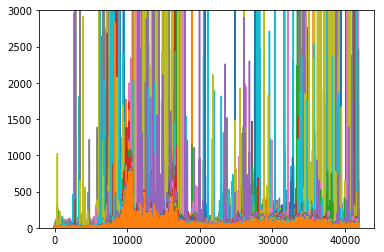

In [12]:
s = 0
plt.figure()
for trialN in range(1): #df.index:
    for ch in ch_col:
        der = abs(np.array(df[ch][trialN][1:]))-abs(np.array(df[ch][trialN][0:-1]))
        s = s+(sum(der>1000)>=1)
        plt.plot(der)
plt.ylim([0, 3000])        
plt.show()

In [13]:
s

50

### Trace exceeds P% of time over mean + n times SD

In [14]:
P = .01
n = 4
df['artifacts'] = np.nan #artifacts
df['artifacts'] = df['artifacts'].astype(object)

for trialN in df.index:
    ch_list = []
    
    for chN, ch in enumerate(ch_col):
        s = (abs(np.array(df[ch][trialN]))>=df[ch+'_mean'][trialN]+n*df[ch+'_std'][trialN]).sum()
        
        if s > P*df['t_steps'][trialN]:
            ch_list.append(chN)
    
    df.at[trialN, 'artifacts'] = ch_list

In [15]:
df['artifacts']

0     [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
1     [8, 56, 140, 141, 146, 162, 163, 164, 165, 170...
2     [8, 40, 41, 48, 51, 58, 59, 60, 63, 66, 67, 68...
3     [48, 57, 130, 131, 138, 139, 140, 170, 173, 17...
4                                            [158, 184]
5     [18, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 4...
6     [5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, ...
7     [4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17...
8     [3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16,...
9     [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
10      [1, 96, 127, 131, 137, 138, 139, 160, 163, 164]
11    [1, 96, 126, 127, 130, 131, 137, 138, 148, 149...
12     [1, 137, 147, 148, 149, 150, 155, 158, 159, 160]
13    [40, 68, 71, 104, 105, 113, 114, 124, 126, 127...
14               [40, 71, 129, 156, 157, 158, 159, 184]
15    [0, 1, 2, 3, 8, 9, 96, 129, 138, 148, 149, 156...
16    [0, 1, 2, 3, 8, 9, 69, 77, 129, 150, 157, 162,...
17    [0, 1, 2, 3, 4, 50, 59, 67, 68, 69, 70, 71

# Clean dataframe from artifacts

In [16]:
df_copy = df.copy()
#df_copy.to_csv(folder+'df_copy') # save copy before cleaning: this is time-consuming, uncomment only if needed

In [17]:
df = df.drop(['set1', 'set2', 'set3','set'], axis=1) # drop redundant data

In [18]:
df['chN_del'] = [ch_man[trialN] for trialN in df.index] # number of bad channels - integers (from manual list)
ch_del = [['ch'+str(i) for i in df['chN_del'][trialN]] for trialN in df.index] # bad channels - strings
df['ch_del'] = ch_del

Dataframe with 0s and 1s for bad and good channels

In [19]:
df_ch = pd.DataFrame(1, columns=ch_col, index=df.index)
for trialN in df.index:
    df_ch.at[trialN, ch_del[trialN]] = [0 for i in ch_del[trialN]] # 0-ing boxes for bad channels
df_ch['ch_del'] = df['ch_del']
df_ch['chN_del'] = df['chN_del']

In [20]:
df[ch_col] = df_ch[ch_col]*df[ch_col] # deleting trace for bad channels
#df.to_csv(folder+'df_clean') # save file with clean dataframe: this is time-consuming, uncomment only if needed
df_ch.to_csv(folder+'df_ch') # save file with 0-1s dataframe

Single files with bad channels for each trial

In [21]:
file_list_ch_del = [file_list[trialN].replace('.mat', '_ch.csv') for trialN in df.index]

for trialN, file_name in enumerate(file_list_ch_del):
    df_ch.loc[[trialN]].to_csv(file_name)

Example to call file

In [30]:
df_read = pd.read_csv(file_name)
df_read = df_read.set_index(df_read.columns[0])
df_read
#df_read.iloc[0] #first row

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,...,ch185,ch186,ch187,ch188,ch189,ch190,ch191,ch192,ch_del,chN_del
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
34,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"['ch2', 'ch137', 'ch147', 'ch148', 'ch149']","[2, 137, 147, 148, 149]"


# Time-frequency decomposition

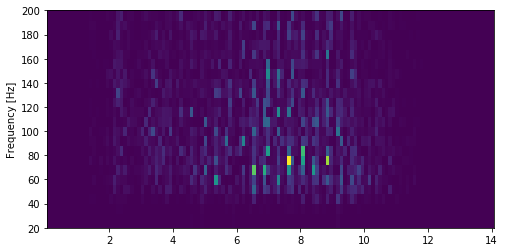

In [31]:
#low Tukey parameter
TASK_NAME = 'knife'
trialN = 3
channelN = 'ch10'

x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
#x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
x = x - x.mean() # delete mean signal

f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 0.001))

plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.ylim([20,200])
plt.show()

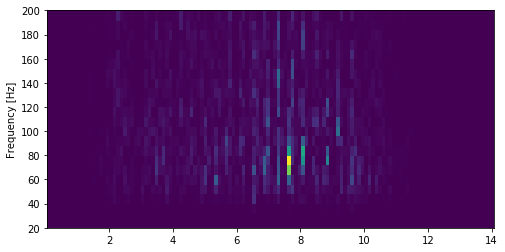

In [32]:
#high Tukey parameter
f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 1))

plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.ylim([20,200])
plt.show()

In [33]:
# look for best time-frequency resolution

In [34]:
p = []
for i in range(1,10000):
    f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 0.001), nperseg=int(len(x)/i))
    p.append(np.size(Sxx))

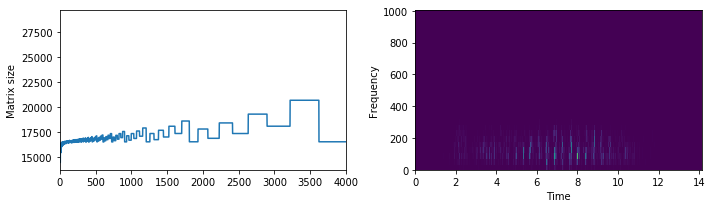

In [35]:
plt.figure(figsize=(10,3))
ax = plt.subplot(121)
ax.plot(p)
ax.set_ylabel('Matrix size')
ax.set_xlim([0, 4000])

i = 500

ax = plt.subplot(122)
f, t, Sxx = signal.spectrogram(x, fs, window=('tukey', 1), nperseg=int(len(x)/i))
ax.pcolormesh(t, f, Sxx)
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

same length for different signals (e.g. 100-150 ms)

In [36]:
f

array([   0.        ,   35.92982456,   71.85964912,  107.78947368,
        143.71929825,  179.64912281,  215.57894737,  251.50877193,
        287.43859649,  323.36842105,  359.29824561,  395.22807018,
        431.15789474,  467.0877193 ,  503.01754386,  538.94736842,
        574.87719298,  610.80701754,  646.73684211,  682.66666667,
        718.59649123,  754.52631579,  790.45614035,  826.38596491,
        862.31578947,  898.24561404,  934.1754386 ,  970.10526316,
       1006.03508772])

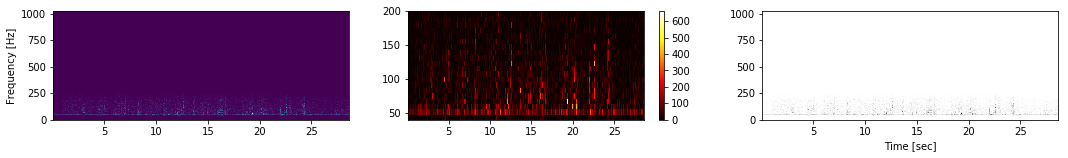

In [37]:
TASK_NAME = 'typing'
trialN = 3
channelN = 'ch9'

x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
#x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
#x = x - x.mean() # delete mean signal

f, t, Sxx = signal.spectrogram(x, fs)

plt.figure(figsize=(18, 2))
ax = plt.subplot(131)
plt.pcolormesh(t, f, Sxx)
ax.set_ylabel('Frequency [Hz]')

ax = plt.subplot(132)
plt.pcolormesh(t, f, Sxx, cmap='hot')
ax.set_ylim([40,200])
#ax.set_xlim([6,8])
plt.colorbar()

ax = plt.subplot(133)
plt.pcolormesh(t, f, Sxx, cmap='binary')

plt.xlabel('Time [sec]')
plt.show()

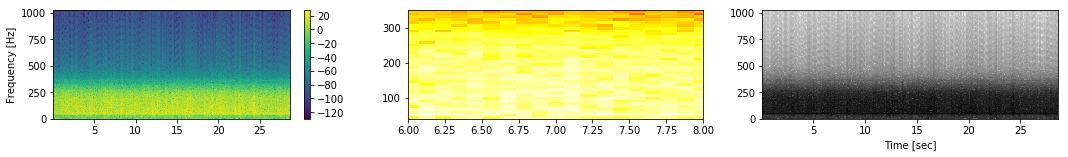

In [38]:
# different plotting, with 10 log_10 scale
f, t, Sxx = signal.spectrogram(x, fs)

plt.figure(figsize=(18, 2))
ax = plt.subplot(131)
plt.pcolormesh(t, f, 10*np.log10(Sxx))
ax.set_ylabel('Frequency [Hz]')
plt.colorbar()

ax = plt.subplot(132)
plt.pcolormesh(t, f, 10*np.log10(Sxx), cmap='hot')
ax.set_ylim([40,350])
ax.set_xlim([6,8])
#plt.colorbar()

ax = plt.subplot(133)
plt.pcolormesh(t, f, 10*np.log10(Sxx), cmap='binary')

plt.xlabel('Time [sec]')
plt.show()

In [39]:
#different package: specgram, plots directly, using 10 log_10 scale

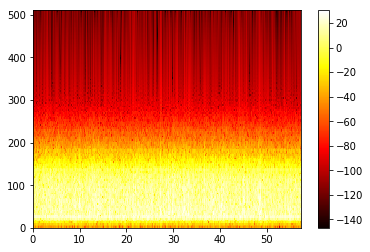

In [40]:
#NFFT = 128
Fs = fs
#noverlap = 

#NFFT = int(Fs*0.05)
#noverlap = int(Fs*0.00000001)

NFFT = 259
noverlap = 129

pylab.figure(1)
pylab.specgram(x, NFFT=NFFT, Fs=Fs/2, noverlap=noverlap, cmap='hot')
plt.colorbar()
plt.show()

In [41]:
# try different task, and removing the mean signal

In [43]:
TASK_NAME = 'screw'
trialN = 4
channelN = 'ch10'

x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
x = x - x.mean()

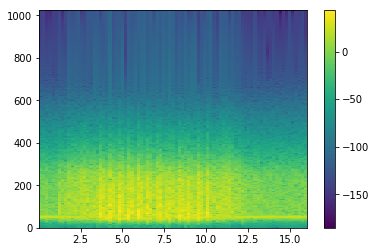

In [44]:
Pxx, freqs, bins, im = plt.specgram(x, NFFT=int(1028/2), Fs=fs)
plt.colorbar()
plt.show()

Compare trials over channels for one task (within subject)

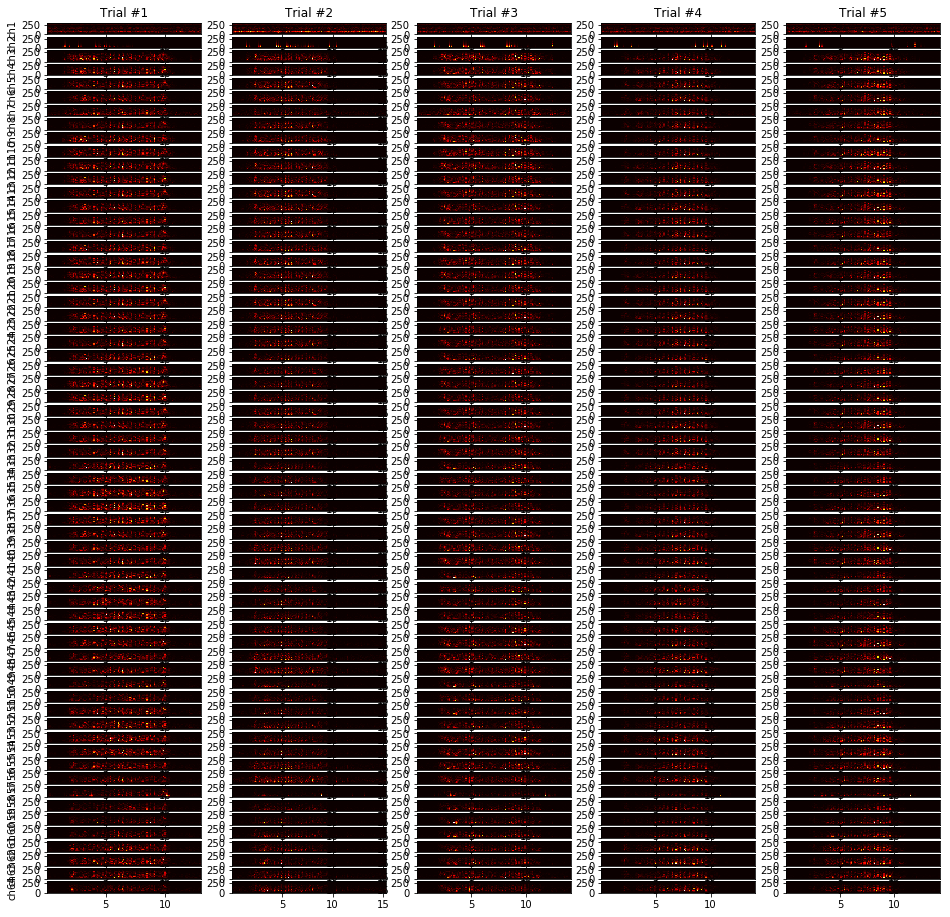

In [46]:
TASK_NAME = 'knife'
trialN_tot = np.size(df[df.task==TASK_NAME],0)

plt.figure(figsize=(16, 16))
 
#for ch in range(n_ch_tot): #each channel, rows
for ch in range(n_ch**2): #each channel, rows
    for trialN in range(trialN_tot): #each trial, columns
        
        ax = plt.subplot(n_ch**2, trialN_tot, trialN_tot*ch+trialN+1)
        #ax = plt.subplot(192, 5, 5*ch+trialN+1 )
        #ax = plt.subplot((n_ch_tot,np.size(df[df.task==TASK_NAME],0),trialN_tot*ch+trialN+1)
        
        channelN = 'ch'+str(ch+1)
        x = np.array(df[df.task==TASK_NAME][channelN].iloc[trialN])
        f, t, Sxx = signal.spectrogram(x, fs)
        ax.pcolormesh(t, f, Sxx, cmap='hot')
        ax.set_ylim([0, 300])
        
        if trialN == 0:
            ax.set_ylabel('ch'+str(ch+1))
            
        if ch == 0:
            ax.set_title('Trial #'+str(trialN+1))
        
        #ax.set_axis_off()
plt.tight_layout
plt.show()

It would be better to split on more columns, on a larger window.

Prediction with just action onset?

All matrix

In [64]:
trialN_tot = max(df.index)+1

Th = .05 # threshold
t_W = 5
f_W = 16

time_dim = np.zeros((n_ch_tot, trialN_tot, t_W))
freq_dim = np.zeros((trialN_tot, n_ch_tot))

p_tot = f_W*t_W*n_ch_tot

df['pred'] = ''

for w in range(p_tot):
    df['p'+str(w)] = ''

for trialN in df.index: #each trial, columns
    
    F = []
    
    for chN, ch in enumerate(ch_col): #each channel, rows

        x = np.array(df[ch].loc[trialN])
        
        #if np.isnan(x[0])==False:
        if x.size > 0:
            f, t, Sxx = signal.spectrogram(x, fs)
        
            ind = np.where(Sxx/np.max(Sxx) > Th) #5% threshold
            time_dim[chN, trialN, :] = np.unique(ind[0])[0:t_W]
            
            freq_dim[trialN, chN] = np.argmax(np.sum(Sxx[:, time_dim[chN,trialN,:].astype(int)], axis=1))
            W = np.reshape(Sxx[0:f_W, time_dim[chN,trialN,:].astype(int)], (t_W*f_W)) #time-frequency window of interest
            F.append(W)
        else:
            W = (np.nan,)*(t_W*f_W) #time-frequency window of interest
            F.append(W)
    
    #df['pred'].loc[trialN] = np.reshape(F, p_tot)
    df.at[trialN, 'pred']= np.reshape(F, p_tot)

df['freq'] = freq_dim.tolist()

A column for each t-f pixel

In [65]:
p_col = df.columns[ df.columns.get_loc('p0') : df.columns.get_loc('p0') + p_tot]

In [66]:
df[p_col] = df['pred'].tolist()

Set ticks for heat map

In [67]:
yticks = []
yticks.append(np.size(df[df.task==task_names[0]].trial)/2)

for i in range(1, len(task_names)):
    yticks.append(np.size(df[df.task==task_names[i]].trial)/2+np.size(df[df.task==task_names[i-1]].trial)/2+yticks[i-1])

Plot heat map

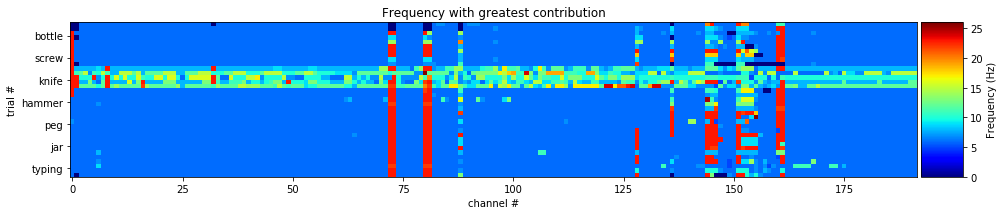

In [68]:
plt.figure(figsize=(16,40))
ax = plt.gca()

im = ax.imshow(freq_dim, interpolation='nearest', cmap=cm.jet, vmax=freq_dim.max(), vmin=0)
#im = ax.imshow(freq_dim, interpolation='nearest', cmap=cm.jet, vmax=10, vmin=0)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax.set_yticks(yticks)
ax.set_yticklabels(task_names)

plt.colorbar(im, cax=cax)
plt.ylabel('Frequency (Hz)')
ax.set_xlabel('channel #')
ax.set_ylabel('trial #')
ax.set_title('Frequency with greatest contribution')
plt.show()

- check time-frequency resolution in spectrogram (check time length from spectogram properties)
- create time-frequency window
- reshape it into array for prediction

## Classifiers

In [69]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

C:\Users\HIWI\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [70]:
predictors=p_col

In [82]:
X = df[predictors].fillna(0, inplace=False)
y = df['task']

In [83]:
X

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p15350,p15351,p15352,p15353,p15354,p15355,p15356,p15357,p15358,p15359
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.412825,4.039638,1.609664,0.035133,2.251248,3.243517,2.130414,0.023938,3.382612,1.149292
1,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.150401,0.969917,2.675944,11.494484,0.517629,1.989920,0.893838,5.529907,3.756028,0.365921
2,0.058066,0.030139,1.668140e-02,0.005360,0.001511,0.003148,0.002158,0.003162,0.000162,0.000307,...,0.068427,0.435979,3.022784,13.696546,25.213808,1.143116,1.855609,1.518017,27.212513,26.273897
3,0.000084,0.007998,9.127310e-03,0.000369,0.027225,0.001552,0.000124,0.002383,0.001302,0.002626,...,0.001594,0.464954,1.206088,1.129178,2.851261,0.415744,0.710184,1.427350,0.867247,0.833835
4,0.051726,0.004553,1.625756e-03,0.000900,0.000039,0.003130,0.001430,0.000949,0.000598,0.000409,...,4.614768,0.319530,0.601378,0.170305,0.480986,7.146988,0.462012,1.108443,0.255569,0.143270
5,0.031294,0.012902,3.885007e-03,0.062326,0.013279,0.004351,0.001383,0.001064,0.000746,0.004736,...,0.404712,0.440937,0.398651,0.181179,2.569482,0.639995,0.169500,0.420696,0.813844,1.210467
6,0.003118,0.015042,1.788837e-02,0.001712,0.008100,0.000018,0.001646,0.000874,0.000927,0.001886,...,0.137311,0.020697,0.584658,0.492929,0.471451,3.268400,3.748147,0.375778,2.507792,1.172804
7,0.000469,0.022476,8.354931e-07,0.002372,0.040318,0.003486,0.000733,0.001341,0.002624,0.000686,...,0.787234,0.255809,1.668699,0.002099,2.887980,1.178576,0.068051,2.146744,0.843904,1.665621
8,0.016125,0.031863,8.806893e-03,0.005173,0.013788,0.000606,0.003753,0.001290,0.000703,0.001631,...,1.007513,0.345387,4.976161,0.508195,1.369599,3.154382,1.077862,1.358327,0.007055,1.701285
9,0.010389,0.000878,3.732734e-02,0.003372,0.002327,0.001192,0.003492,0.004086,0.000369,0.003921,...,1.999366,0.630459,0.745246,0.308047,0.946826,0.787096,0.075213,0.450046,0.303952,0.193947


In [90]:
y

0     bottle
1     bottle
2     bottle
3     bottle
4     bottle
5      screw
6      screw
7      screw
8      screw
9      screw
10     knife
11     knife
12     knife
13     knife
14     knife
15    hammer
16    hammer
17    hammer
18    hammer
19    hammer
20       peg
21       peg
22       peg
23       peg
24       peg
25       jar
26       jar
27       jar
28       jar
29       jar
30    typing
31    typing
32    typing
33    typing
34    typing
Name: task, dtype: object

Use imputer from sklearn

In [91]:
#SVM = sklearn.svm.SVC(kernel='rbf')
#SVM.fit(X, y)  
#SVM.score(X,y)

rfc = RandomForestClassifier()
rfc.fit(X, y)
rfc.score(X,y)

1.0

In [92]:
#scoreSVM=([]);
scoreRFC=([]);

In [93]:
kf = KFold(n_splits=5) 
#KFold(n_splits=2, random_state=None, shuffle=False)

In [94]:
for train,test in kf.split(X):
    
    ## SVM
    #SVM =  sklearn.svm.SVC(kernel='rbf')
    #SVM.fit(X.iloc[train],y.iloc[train])
    #scoreSVM.append(SVM.score(X.iloc[test], y.iloc[test])) #accuracy
    
    ## RFC
    RFC =  RandomForestClassifier()
    RFC.fit(X.iloc[train],y.iloc[train])
    scoreRFC.append(RFC.score(X.iloc[test], y.iloc[test])) #accuracy

In [95]:
#print (np.mean(scoreSVM))
#print (np.std(scoreSVM))
#print ()
print (np.mean(scoreRFC))
print (np.std(scoreRFC))
print ('chance line=', 1/len(task_names))

0.08571428571428572
0.11428571428571428
chance line= 0.14285714285714285


With NaN, after artefact pre-processing

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

X_train = [[0, 0, np.nan], [np.nan, 1, 1]]
Y_train = [0, 1]
X_test_1 = [0, 0, np.nan]
X_test_2 = [0, np.nan, np.nan]
X_test_3 = [np.nan, 1, 1]

# Create our imputer to replace missing values with the mean e.g.
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train_imp, Y_train)

for X_test in [X_test_1, X_test_2, X_test_3]:
    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)
    print(X_test, '->', clf.predict(X_test_imp))